In [1]:
#%pip install git+https://github.com/jgieseler/solo-epd-loader --upgrade
#%pip install calc_electrons

In [2]:
from SOLO_loaders import solo_mag_loader
from solo_functions import calc_pa_coverage, calc_av_en_flux_EPD, calc_EPT_corrected_e, print_HET_energies, print_EPT_energies
from epd_plot_shift import *
from run_the_fit import *
#from solo_epd_loader import calc_electrons
from solo_epd_loader import epd_load, calc_electrons, combine_pixels # import via pip
import datetime as dt
from pandas.tseries.frequencies import to_offset
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
from matplotlib.ticker import AutoMinorLocator 
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.size'] = 10
plt.rcParams['agg.path.chunksize'] = 20000
import numpy as np
import pandas as pd
import sys


col_list = plt.cm.rainbow(np.linspace(0.,0.95,16))

/home/annafed/anaconda3/envs/annamaria/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
outpath = r'/home/annafed/Documents/STIX_EPD_event_analysis/STEP_EPD_comparison/'
intensity_label = 'Flux\n/(s cm² sr MeV)'

save_fig = False
save = True

date = datetime(2022, 4, 15, 3, 2) #onset time or event ID inj time specified later
t_inj = str(date)[:-3].replace(' ', '-').replace(':', '')
date_folder = t_inj

year = 2022
startdate = dt.datetime(year, 4, 15, 3, 0)
enddate = dt.datetime(year, 4, 15, 4, 0)


mag_data_product = 'l2'# 'l2', 'll'
data_product = 'l2'
instrument = 'EPT'
species = 'e' # e or p
direction = 'sun'
ept_ion_conta_corr = True  # if true EPT electron fluxes are corrected for ion contamination
plot_pa_cov = True



av = 1  # needed for solo_mag_loader
averaging = f'{av}min' 

## EPT:
en_channel = 2
## en_channel: when a list of two elements is provided, an averaged energy channel is used (not yet supported for STEP!). 
## If only one element is provided, then only this one channel is used.

## STEP
step_en_channel = 25


#-----------------
if species in ['e', 'electrons']:
    step_species = 'Electron'
if species in ['p', 'i', 'protons', 'ions']:
    step_species = 'Magnet'



In [4]:
print(averaging)

1min


# LOAD DATA

In [5]:
path =  r'/home/annafed/Documents/STIX_EPD_event_analysis/STEP_EPD_comparison/'
downloadpath = f'{path}l2/epd/{instrument}/'
sdate = int(f'{startdate.date()}'.replace('-', ''))
edate = int(f'{enddate.date()}'.replace('-', ''))



# MAG and PA coverage
print('Loading MAG...')
msdate = dt.datetime.combine(startdate.date(), dt.time.min)
medate = dt.datetime.combine(enddate.date()+ dt.timedelta(days=1), dt.time.min) #+ dt.timedelta(days=1)
enddate_epd = dt.datetime.combine(enddate.date(), dt.time.max)
try:
    mag_srf = solo_mag_loader(msdate, medate, level=mag_data_product, frame='srf', av=averaging, path=path)
except:
    print('changing mag data product to LL')
    mag_type = 'LL'
    mag_srf = solo_mag_loader(msdate, medate, level=mag_data_product,frame='srf', av=averaging, path=path)

mag_srf = mag_srf[mag_srf.index <= enddate_epd]

coverage = calc_pa_coverage(instrument, mag_srf)
coverage_step = calc_pa_coverage('step', mag_srf)




print('Loading STEP...')
df_particles_step_org, energies_step = epd_load('step', level=data_product, startdate=sdate, enddate=edate, path=path, autodownload=True)

print('Loading '+instrument+'...')
if instrument in ['EPT', 'HET']:
    df_sun_p, df_sun_e, energies = epd_load(instrument, level=data_product, startdate=sdate, enddate=edate, viewing='sun', path=path, autodownload=True)

Loading MAG...
Loading MAG...


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]
solo_l2_mag-srf-normal_20220415_v01.cdf:   0%|          | 0.00/13.1M [00:00<?, ?B/s]
solo_l2_mag-srf-normal_20220415_v01.cdf:   0%|          | 1.02k/13.1M [00:00<2:20:26, 1.55kB/s]
solo_l2_mag-srf-normal_20220415_v01.cdf:   0%|          | 25.0k/13.1M [00:00<05:24, 40.3kB/s]  
solo_l2_mag-srf-normal_20220415_v01.cdf:   1%|          | 105k/13.1M [00:00<01:15, 173kB/s]  
solo_l2_mag-srf-normal_20220415_v01.cdf:   1%|▏         | 185k/13.1M [00:01<00:46, 281kB/s]
solo_l2_mag-srf-normal_20220415_v01.cdf:   3%|▎         | 417k/13.1M [00:01<00:19, 652kB/s]
solo_l2_mag-srf-normal_20220415_v01.cdf:   6%|▌         | 769k/13.1M [00:01<00:10, 1.22MB/s]
solo_l2_mag-srf-normal_20220415_v01.cdf:   8%|▊         | 1.07M/13.1M [00:01<00:07, 1.64MB/s]
solo_l2_mag-srf-normal_20220415_v01.cdf:  14%|█▍        | 1.85M/13.1M [00:01<00:04, 2.66MB/s]
solo_l2_mag-srf-normal_20220415_v01.cdf:  20%|██        | 2.66M/13.1M [00:01<00:02, 3.90MB/s]
solo_l2_mag-

Calculating PA coverage for EPT...


100%|██████████| 1440/1440 [00:00<00:00, 9812.75it/s] 


Calculating PA coverage for step...
Opening of STEP just a placeholder! Replace with real value! This affects the 'min' and 'max' values of the pitch-angle, not the 'center' ones.


100%|██████████| 1440/1440 [00:00<00:00, 2733.67it/s]


Loading STEP...


solo_L2_epd-step-main_20220415_V01.cdf: 84.0MB [01:06, 1.26MB/s]                              


Loading /home/annafed/Documents/STIX_EPD_event_analysis/STEP_EPD_comparison/l2/epd/step/solo_L2_epd-step-main_20220415_V01.cdf
Loading EPT...


solo_L2_epd-ept-asun-rates_20220415_V02.cdf: 3.37MB [00:03, 952kB/s]                             
solo_L2_epd-ept-north-rates_20220415_V02.cdf: 3.69MB [00:03, 1.01MB/s]                            
solo_L2_epd-ept-south-rates_20220415_V02.cdf: 3.79MB [00:03, 1.02MB/s]                            
solo_L2_epd-ept-sun-rates_20220415_V02.cdf: 4.99MB [00:06, 737kB/s]                             


In [6]:
#df_particles_step_org

## print energy channels

In [7]:
print_EPT_energies(energies)  # for HET: print_HET_energies(energies)


Ions
0 ['0.0495 - 0.0574 MeV']
1 ['0.0520 - 0.0602 MeV']
2 ['0.0552 - 0.0627 MeV']
3 ['0.0578 - 0.0651 MeV']
4 ['0.0608 - 0.0678 MeV']
5 ['0.0645 - 0.0718 MeV']
6 ['0.0689 - 0.0758 MeV']
7 ['0.0729 - 0.0798 MeV']
8 ['0.0768 - 0.0834 MeV']
9 ['0.0809 - 0.0870 MeV']
10 ['0.0870 - 0.0913 MeV']
11 ['0.0913 - 0.0974 MeV']
12 ['0.0974 - 0.1034 MeV']
13 ['0.1034 - 0.1096 MeV']
14 ['0.1096 - 0.1173 MeV']
15 ['0.1173 - 0.1246 MeV']
16 ['0.1246 - 0.1333 MeV']
17 ['0.1333 - 0.1419 MeV']
18 ['0.1419 - 0.1514 MeV']
19 ['0.1514 - 0.1628 MeV']
20 ['0.1628 - 0.1744 MeV']
21 ['0.1744 - 0.1879 MeV']
22 ['0.1879 - 0.2033 MeV']
23 ['0.2033 - 0.2189 MeV']
24 ['0.2189 - 0.2364 MeV']
25 ['0.2364 - 0.2549 MeV']
26 ['0.2549 - 0.2744 MeV']
27 ['0.2744 - 0.2980 MeV']
28 ['0.2980 - 0.3216 MeV']
29 ['0.3216 - 0.3494 MeV']
30 ['0.3494 - 0.3810 MeV']
31 ['0.3810 - 0.4117 MeV']
32 ['0.4117 - 0.4472 MeV']
33 ['0.4472 - 0.4850 MeV']
34 ['0.4850 - 0.5255 MeV']
35 ['0.5255 - 0.5734 MeV']
36 ['0.5734 - 0.6216 MeV']
37 ['

In [8]:
energies_step

{'Bins_Low_Energy': array([0.005725, 0.006103, 0.006521, 0.006998, 0.007548, 0.008154,
        0.008802, 0.009491, 0.01026 , 0.01109 , 0.01198 , 0.01297 ,
        0.01405 , 0.01516 , 0.01655 , 0.01786 , 0.01933 , 0.02092 ,
        0.02261 , 0.02446 , 0.02652 , 0.0287  , 0.03101 , 0.03346 ,
        0.03618 , 0.0394  , 0.04254 , 0.04589 , 0.04977 , 0.0539  ,
        0.05826 , 0.06288 ], dtype=float32),
 'Bins_Width': array([0.003233, 0.003021, 0.002852, 0.002754, 0.002682, 0.002626,
        0.002598, 0.002599, 0.00261 , 0.00261 , 0.0026  , 0.00269 ,
        0.00278 , 0.00288 , 0.00272 , 0.00272 , 0.00278 , 0.00279 ,
        0.00281 , 0.0029  , 0.00295 , 0.003   , 0.00305 , 0.00319 ,
        0.00322 , 0.00314 , 0.00335 , 0.00388 , 0.00413 , 0.00436 ,
        0.00462 , 0.00512 ], dtype=float32),
 'Bins_Text': array([['0.0057 - 0.0090 MeV'],
        ['0.0061 - 0.0091 MeV'],
        ['0.0065 - 0.0094 MeV'],
        ['0.0070 - 0.0098 MeV'],
        ['0.0075 - 0.0102 MeV'],
        ['0.0082 - 

# time averaging and EPT ion conta corr

In [9]:
if averaging is not None:
    coverage = coverage.resample(averaging,label='left').mean()
    coverage.index = coverage.index + to_offset(pd.Timedelta(averaging)/2)
    
    #if instrument == 'STEP':
    if species == 'e':
        contamination_threshold = 2
        df_step = calc_electrons(df=df_particles_step_org, meta=energies_step, 
                                   contamination_threshold=contamination_threshold, only_averages=False,
                                   resample=averaging)
        df_step_inner = combine_pixels(df=df_step, meta=energies_step, pixels=['02', '03', '04', '07', '08', '09', '12', '13', '14'])
    else:
        None
        # to do: implement ion fluxes
        #df_sun = df_particles_step_org  
        
        
    if instrument in ['EPT', 'HET']:
        df_sun_p   = df_sun_p.resample(averaging,label='left').mean()
        df_sun_p.index = df_sun_p.index + to_offset(pd.Timedelta(averaging)/2)
    
    if instrument in ['EPT', 'HET']:
        df_sun_e   = df_sun_e.resample(averaging,label='left').mean()
        df_sun_e.index = df_sun_e.index + to_offset(pd.Timedelta(averaging)/2)

if instrument=='EPT':
    if ept_ion_conta_corr:
        df_sun_e = calc_EPT_corrected_e(df_sun_e['Electron_Flux'], df_sun_p['Ion_Flux'])




100%|██████████| 1024/1024 [01:29<00:00, 11.48it/s]


In [10]:
#df_step_inner['Electron_Comb_Flux_22']
df_step_inner

,DELTA_EPOCH,Integral_01_Uncertainty_0,Integral_01_Uncertainty_1,Integral_01_Uncertainty_2,Integral_01_Uncertainty_3,Integral_01_Uncertainty_4,Integral_01_Uncertainty_5,Integral_01_Uncertainty_6,Integral_01_Uncertainty_7,Integral_01_Uncertainty_8,...,Electron_Comb_Uncertainty_22,Electron_Comb_Uncertainty_23,Electron_Comb_Uncertainty_24,Electron_Comb_Uncertainty_25,Electron_Comb_Uncertainty_26,Electron_Comb_Uncertainty_27,Electron_Comb_Uncertainty_28,Electron_Comb_Uncertainty_29,Electron_Comb_Uncertainty_30,Electron_Comb_Uncertainty_31
Time,,,,,,,,,,,,,,,,,,,,,
2022-04-15 00:00:30.204801,60,1.535312e+06,1.090348e+06,1.120488e+06,567133.880469,325780.764453,227601.918975,277172.761458,238988.074491,218296.384953,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-04-15 00:01:30.204801,60,1.810264e+06,1.496843e+06,8.470092e+05,510270.434947,325780.769818,194906.637079,208381.089840,277679.049734,173216.446543,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-04-15 00:02:30.204801,60,1.553922e+06,1.369211e+06,8.644752e+05,580480.033055,430967.449094,281834.530731,305819.826307,302298.660568,201478.439835,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-04-15 00:03:30.204801,60,1.794315e+06,1.171221e+06,1.234718e+06,848447.304637,625592.399235,439768.676033,404561.607880,406982.027525,311563.092902,...,2562.569311,10551.132759,0.000000,0.00000,0.000000,1559.746083,0.000000,0.000000,0.000000,0.000000
2022-04-15 00:04:30.204801,60,1.794315e+06,1.300706e+06,1.107068e+06,762900.223159,508625.065790,366997.062670,346767.090137,374075.507040,288013.996349,...,12824.898913,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-15 23:55:30.204801,60,1.149922e+06,1.025516e+06,6.469140e+05,446218.550920,244335.575724,211885.856590,191682.728700,168990.088095,84022.318258,...,18803.419560,3166.973308,10803.986461,0.00000,9019.083029,378.816821,0.000000,1393.702171,0.000000,0.000000
2022-04-15 23:56:30.204801,60,1.072308e+06,8.816633e+05,5.989260e+05,510270.434947,304740.004770,176299.689342,129232.469326,177238.299648,118825.502022,...,0.000000,4511.217703,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-04-15 23:57:30.204801,60,9.591015e+05,8.816633e+05,7.732101e+05,495035.035509,270123.142058,185836.189700,200206.080596,151149.329802,111151.079344,...,6259.350495,0.000000,0.000000,0.00000,9741.723184,1743.849134,0.000000,0.000000,324.930338,2596.774348


In [11]:
df_sun_e

,Electron_Flux_0,Electron_Flux_1,Electron_Flux_2,Electron_Flux_3,Electron_Flux_4,Electron_Flux_5,Electron_Flux_6,Electron_Flux_7,Electron_Flux_8,Electron_Flux_9,...,Electron_Flux_24,Electron_Flux_25,Electron_Flux_26,Electron_Flux_27,Electron_Flux_28,Electron_Flux_29,Electron_Flux_30,Electron_Flux_31,Electron_Flux_32,Electron_Flux_33
Time,,,,,,,,,,,,,,,,,,,,,
2022-04-15 00:00:30,NaN,3054.217187,1966.661871,2319.507161,415.869828,1209.977633,299.459817,288.736206,1142.617260,657.621764,...,-0.000407,-0.000179,0.000000,38.311478,-0.000476,-0.000491,37.866673,-0.000803,-0.029261,-2.408937
2022-04-15 00:01:30,NaN,2403.495326,1929.705445,2748.231881,2462.857068,1179.151129,1467.931762,1126.911899,430.626483,850.880105,...,50.724141,-0.305706,-0.107546,-0.018808,-0.006657,-0.003380,-0.332345,-5.002025,-21.562378,-45.357099
2022-04-15 00:02:30,NaN,4342.040514,1494.263740,1410.244784,1687.291114,1636.295080,605.225388,2052.113404,1158.499320,665.227591,...,-11.233408,-10.049732,36.477804,34.180011,-1.868349,36.156870,-0.009951,46.419881,51.006477,-0.001130
2022-04-15 00:03:30,NaN,4266.474386,2449.821686,1384.236718,1241.089266,2817.493599,1492.634670,862.005491,681.787892,215.843002,...,51.574845,-0.020861,-0.007739,38.310047,39.739551,-0.000954,37.866390,-0.001814,50.126787,-2.410274
2022-04-15 00:04:30,NaN,3051.591547,1963.947669,1388.919720,1244.915623,1610.270705,296.140787,573.938659,910.108275,214.790178,...,-6.844760,41.679966,-4.700929,30.949062,-10.096115,-9.749785,32.197089,-1.144746,-0.031146,120.735939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-15 23:55:30,NaN,14584.359628,9764.094627,18957.707224,12004.851291,6400.437611,8338.805404,10063.535544,6815.373266,6099.344490,...,285.597234,206.927825,193.886670,14.134285,133.352790,8.052490,43.971271,11.099275,-33.787868,-29.049894
2022-04-15 23:56:30,NaN,15175.189396,13188.568820,13838.624023,9910.439110,8403.776909,11022.384365,9474.987552,5663.176280,9159.139034,...,503.898067,128.037776,166.033050,33.295328,114.760066,24.003033,-30.366137,-44.637183,15.685443,-14.375049
2022-04-15 23:57:30,NaN,16429.455078,17643.223828,13865.994108,12015.908602,8024.571828,7151.346717,5742.254531,6368.862473,6110.232965,...,360.697145,230.342614,217.126064,114.921363,79.476490,35.854694,151.466111,45.647266,50.158504,60.367970


In [12]:
if species in ['e', 'electrons']:
    if instrument in ['EPT', 'HET']:
        df_sun = df_sun_e
    en_str = energies['Electron_Bins_Text']
    ch_string = 'Electrons'
    if instrument == 'EPT':
        if ept_ion_conta_corr:
            ch_string = 'Electrons (corr)'
    
if species in ['p', 'i', 'protons', 'ions']:
    if instrument in ['EPT', 'HET']:
        df_sun = df_sun_p
    if instrument in ['STEP', 'EPT']: 
        en_str = energies['Ion_Bins_Text']
        ch_string = 'Ions'
    if instrument == 'HET': 
        en_str = energies['H_Bins_Text']
        ch_string = 'Protons'



######################################################################################
#if instrument == 'STEP':
if species in ['e', 'electrons']:
    en_channel_string_step = energies_step['Bins_Text'][step_en_channel][0]
if species in ['p', 'i', 'protons', 'ions']:
    en_channel_string_step = energies_step['Bins_Text'][step_en_channel]

# EPT / HET    
I_sun, en_channel_string = calc_av_en_flux_EPD(df_sun, energies, en_channel, species, instrument)




# MAKE THE PLOT

In [13]:
#startdate = dt.datetime(year, 11, 1, 2, 30)
#enddate = dt.datetime(year, 11, 1, 3, 30)



<IPython.core.display.Javascript object>


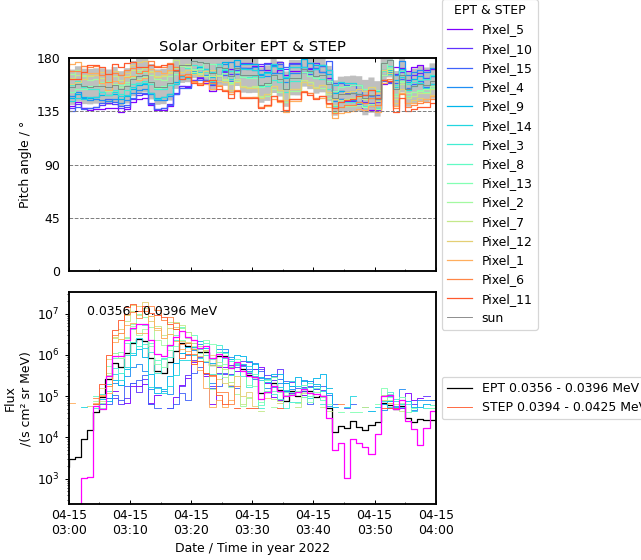

FileNotFoundError: [Errno 2] No such file or directory: '/home/annafed/Documents/STIX_EPD_event_analysis/STEP_EPD_comparison/2022-04-15-0302/plots/STEP-EPT-comparison-PA-sun-1min.png'

In [14]:
%matplotlib notebook
panels = 1
if plot_pa_cov:
    panels = panels +1 
if panels <=2:
    figsize = (8,7)
if 2 < panels <=5:
    figsize = (8,5)
if panels > 5:
    figsize = (7,9)
fig, axes = plt.subplots(panels, figsize=figsize, sharex=True) #figsize=(9,7)
#color = {'sun':'crimson','asun':'orange', 'north':'darkslateblue', 'south':'c'}
color = {'sun':'gray'}
axnum = 0

plist = [5,10,15,4,9,14,3,8,13,2,7,12,1,6,11]  # STEP pixel list


ax = axes[axnum]
if instrument in ['HET', 'EPT']:    
    flux_dic = {'sun': I_sun}#, 'asun':I_asun, 'north':I_north, 'south':I_south}

if plot_pa_cov:
    # Pitch angle coverage:
    ####################################################################
    # instrument == 'STEP':
    for i in range(15):
        p = plist[i]
        ax.plot(coverage_step.index, coverage_step[f'Pixel_{p}']['center'], color = col_list[i], 
                linewidth=1, label=f'Pixel_{p}', drawstyle='steps-mid')
    if instrument in ['HET', 'EPT']: 
        #for direction in ['sun', 'asun', 'north', 'south']: 
        col = color[direction]
        # fill the minimum-maximum range of the pitch angle coverage
        ax.fill_between(coverage.index, coverage[direction]['min'], coverage[direction]['max'], alpha=0.5, color=col, edgecolor=col, linewidth=0.0, step='mid')
        # plot the central pitch angle as a thin line
        ax.plot(coverage.index, coverage[direction]['center'], linewidth=0.7, label=direction, color=col, drawstyle='steps-mid')



    ax.axhline(y=90, color='gray', linewidth=0.8, linestyle='--')
    ax.axhline(y=45, color='gray', linewidth=0.8, linestyle='--')
    ax.axhline(y=135, color='gray', linewidth=0.8, linestyle='--')


    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title=instrument+ ' & STEP')
    ax.set_ylim([0, 180])
    ax.yaxis.set_ticks(np.arange(0, 180+45, 45))
    ax.set_xlim([coverage.index[0], coverage.index[-1]])
    ax.set_ylabel('Pitch angle / °')
    ax.tick_params(axis="x",direction="in", which='both', pad=-15)
    ax.tick_params(labelbottom=False, labeltop=False, labelleft=True, labelright=False, bottom=True, top=True, left=False, right=False)
    axnum = axnum + 1
    

# Intensities
if instrument in ['HET', 'EPT']: 
    ax = axes[axnum]
    av_flux = flux_dic[direction]
    ax.plot(av_flux.index.values, av_flux.values, linewidth=1, label=instrument+' '+en_channel_string, color='k', drawstyle='steps-mid')

# instrument == 'STEP':
for i in range(15):
    p = plist[i]
    ax = axes[axnum]
    ax.plot(df_step.index, df_step[f'{step_species}_{p:02d}_Flux_{step_en_channel}'].values, color = col_list[i],
            linewidth=0.7, drawstyle='steps-mid')

    
ax.plot(df_step_inner.index, df_step_inner[f'{step_species}_Comb_Flux_{step_en_channel}'].values, color = 'magenta',
            linewidth=1, drawstyle='steps-mid')
    
    
# this is just for the step energy label:    
p=1
ax.plot([np.nan], [np.nan], color = col_list[i],
        linewidth=0.7, drawstyle='steps-mid', label='STEP '+en_channel_string_step)


ax.text(0.05, 0.94, en_channel_string, horizontalalignment='left', verticalalignment='top', transform = ax.transAxes)
ax.set_yscale('log')
ax.set_ylabel(intensity_label)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.tick_params(axis="x",direction="in", which='both')#, pad=-15)
axnum = axnum + 1




ax.set_xlim(startdate, enddate)
#########################
ax = axes[-1]
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d\n%H:%M"))
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Date / Time in year '+str(year))
axes[0].set_title(f'Solar Orbiter EPT & STEP')




plt.tight_layout()
fig.subplots_adjust(hspace=0.1)



if save_fig:
    en_ch_str = str(en_channel).replace('[', '')
    en_ch_str = en_ch_str.replace(']', '')
    en_ch_str = en_ch_str.replace(' ', '')
    en_ch_str = en_ch_str.replace(',', '-')
    plt.savefig(f'{outpath}{instrument}_EPT_vs_STEP_Pixels_{str(sdate)}_{species}_ch{en_ch_str}_{averaging}.png')
    plt.close()
else:
    plt.show()
    
if save:
    plt.savefig(path +date_folder+ '/plots/STEP-EPT-comparison-PA-'+direction+'-'+averaging+'.png', dpi=300, bbox_inches='tight')


<IPython.core.display.Javascript object>


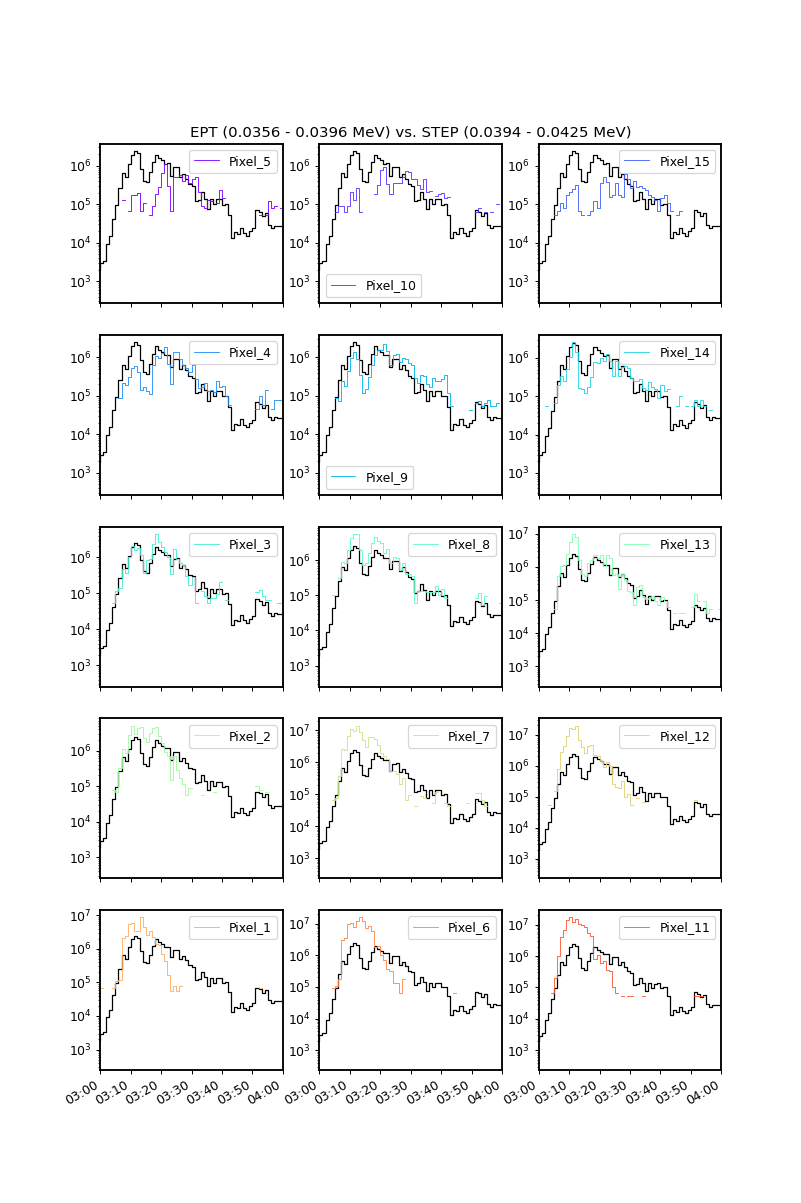

FileNotFoundError: [Errno 2] No such file or directory: '/home/annafed/Documents/STIX_EPD_event_analysis/STEP_EPD_comparison/2022-04-15-0302/plots/STEP-EPT-comparison-pixels-intensity-sun-1min.png'

In [15]:
#%matplotlib notebook
f, axes = plt.subplots(5,3, figsize=(10, 15), sharex=True)
p=0
plist = [5,10,15,4,9,14,3,8,13,2,7,12,1,6,11]
for i, ax in enumerate(axes.flat):
    p=plist[i]
    av_flux = flux_dic[direction]
    ax.plot(av_flux.index.values, av_flux.values, linewidth=1, color='k', drawstyle='steps-mid')
    ax.plot(df_step.index, df_step[f'{step_species}_{p:02d}_Flux_{step_en_channel}'].values, color = col_list[i],
            linewidth=0.7, drawstyle='steps-mid',label=f'Pixel_{p}')
    ax.set_yscale('log')
    ax.legend()
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_xlim(startdate, enddate)
axes.flat[1].set_title(f'EPT ({en_channel_string}) vs. STEP ({en_channel_string_step})')
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
#plt.savefig(path +date_folder+ '/plots/STEP-EPT-comparison-PA-'+direction+'-'+averaging+'.png', dpi=300, bbox_inches='tight')

if save:
    plt.savefig(path +date_folder+ '/plots/STEP-EPT-comparison-pixels-intensity-'+direction+'-'+averaging+'.png')#, dpi=300, bbox_inches='tight')



In [16]:
print('STEP-EPT-comparison-PA-'+direction+'-'+averaging)
print('STEP-EPT-comparison-pixels-intensity-'+direction+'-'+averaging)

STEP-EPT-comparison-PA-sun-1min
STEP-EPT-comparison-pixels-intensity-sun-1min
